## E-commerce Customer Churn Classification
### By: Muhammad Naufal Maahir (JCDS2804016)
## Latar Belakang dan Tujuan
E-commerce saat ini mengalami tantangan utama berupa tingginya tingkat churn pelanggan (berhentinya pelanggan dari penggunaan layanan). Dengan mengidentifikasi pelanggan yang berisiko churn lebih awal, perusahaan dapat merancang intervensi dan strategi retensi secara proaktif.

**Tujuan analisa ini** adalah membangun model machine learning klasifikasi yang dapat memprediksi apakah seorang pelanggan akan churn atau tidak berdasarkan perilaku historisnya. Model ini diharapkan dapat memberikan interpretasi yang kuat dan dapat di-deploy untuk digunakan pada data baru.

---

In [1]:

import pandas as pd
import numpy as np
from packaging import version

## Import Data

In [2]:
df = pd.read_csv('data_ecommerce_customer_churn.csv')
print(f"Pandas version: {pd.__version__}")
print(f"Data shape: {df.shape}")
df.head(5)

Pandas version: 2.2.2
Data shape: (3941, 11)


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


## Data Understanding & Exploratory Data Analysis (EDA)

In [3]:

df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB
Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat  

### Deskripsi Dataset
- **Jumlah data:** 3941 entri dengan 11 fitur
- **Fitur target:** `Churn` (0 = tidak churn, 1 = churn)
- **Tipe data:**
  - Numerik: `Tenure`, `WarehouseToHome`, `NumberOfDeviceRegistered`, `SatisfactionScore`, `NumberOfAddress`, `DaySinceLastOrder`, `CashbackAmount`
  - Kategorikal: `PreferedOrderCat`, `MaritalStatus`
  - Biner: `Complain`

### Missing Values:
| Fitur                | Jumlah Missing |
|----------------------|----------------|
| Tenure               | 194            |
| WarehouseToHome      | 169            |
| DaySinceLastOrder    | 213            |

----


### Penanganan Missing Value:
- Imputasi median untuk data numerik.
- Imputasi modus untuk data kategorikal.

In [4]:
from sklearn.impute import SimpleImputer
num_cols = ['Tenure','WarehouseToHome','NumberOfDeviceRegistered','SatisfactionScore','NumberOfAddress','DaySinceLastOrder','CashbackAmount']
cat_cols = ['PreferedOrderCat','MaritalStatus','Complain']
imp_num = SimpleImputer(strategy='median')
imp_cat = SimpleImputer(strategy='most_frequent')
# Terapkan imputasi
df[num_cols] = imp_num.fit_transform(df[num_cols])
df[cat_cols] = imp_cat.fit_transform(df[cat_cols])

---

## Eksplorasi Data dan Visualisasi

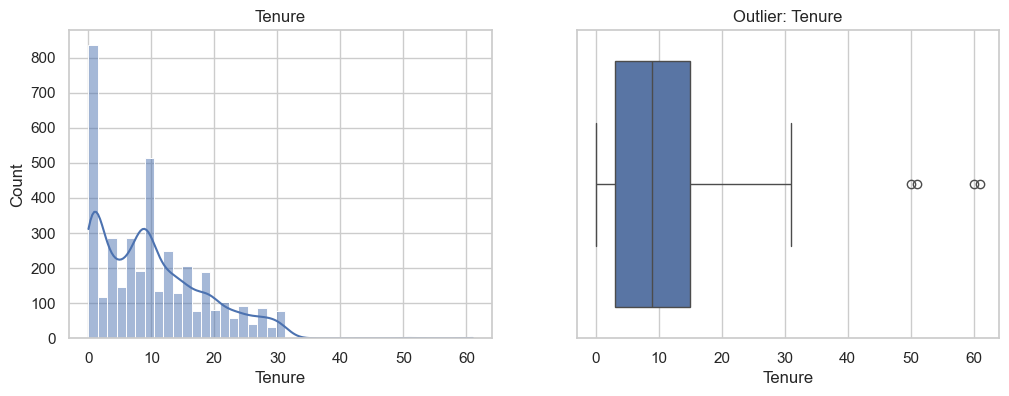

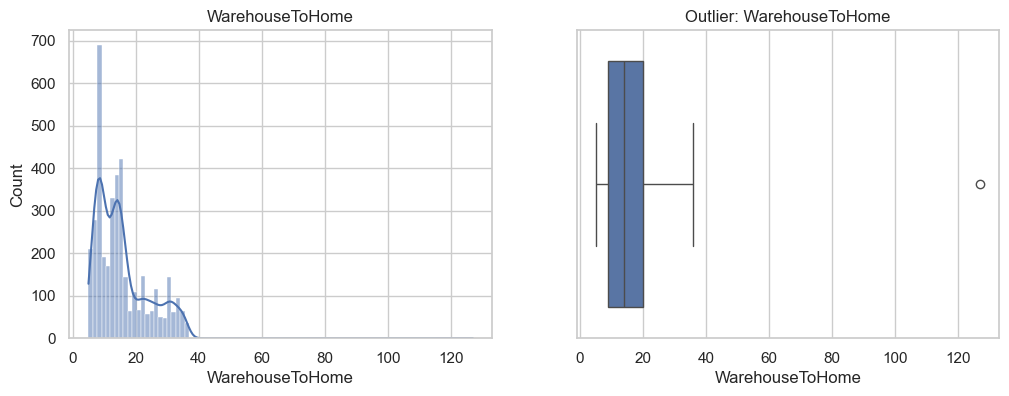

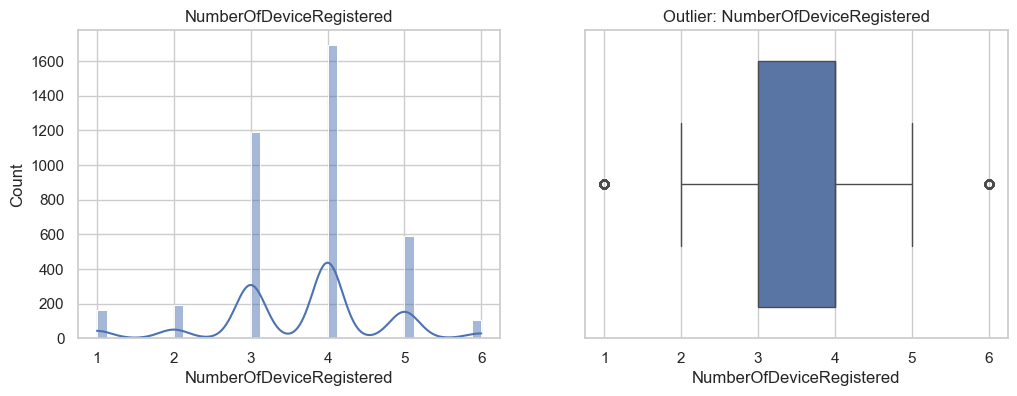

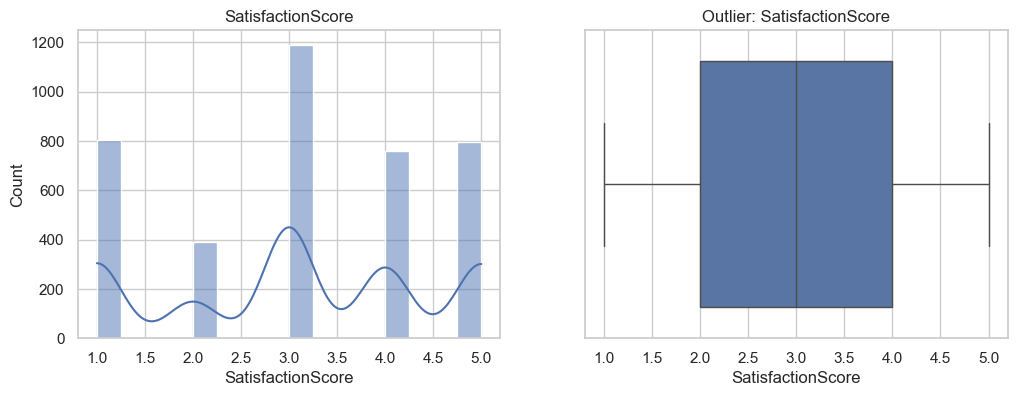

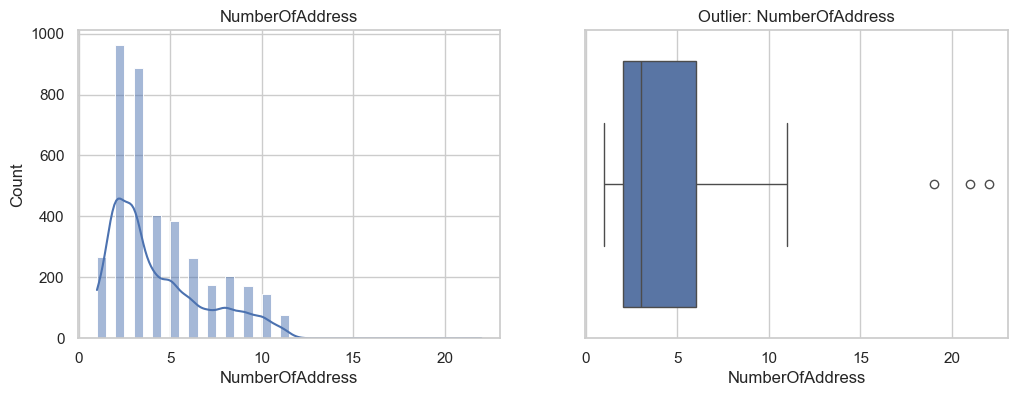

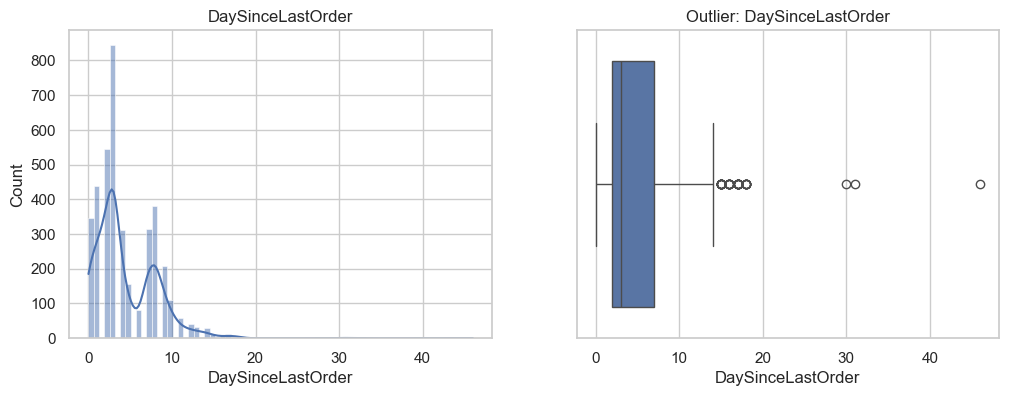

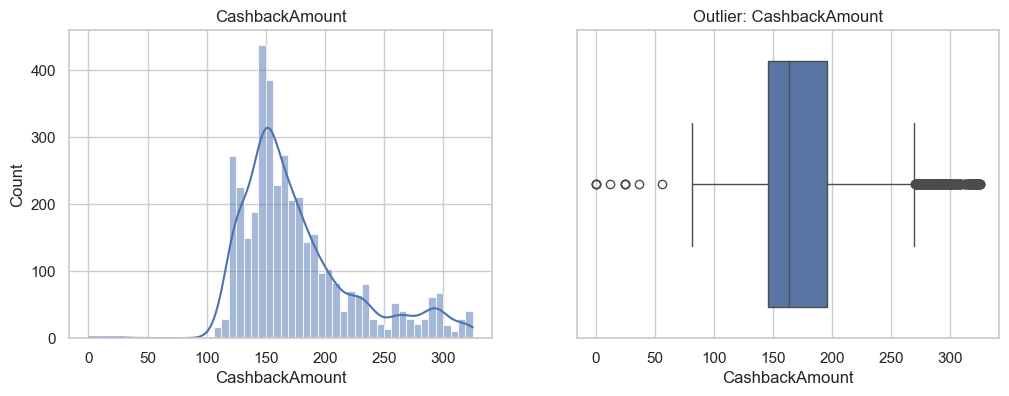

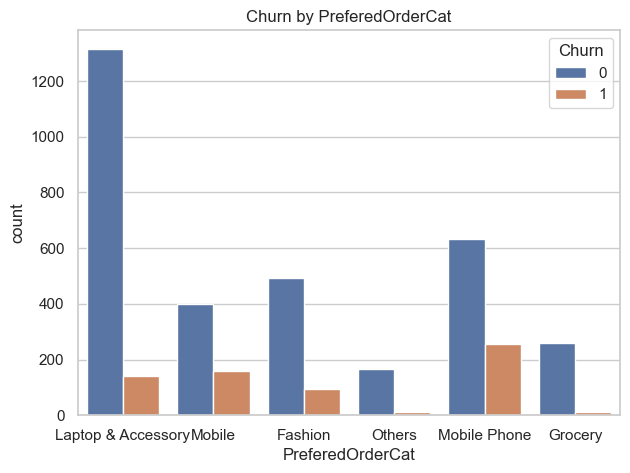

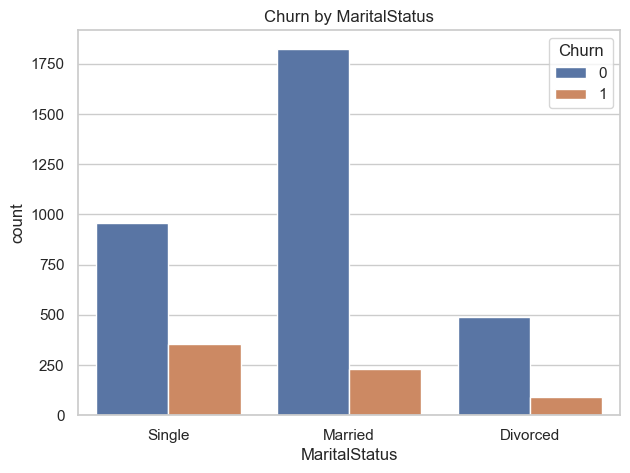

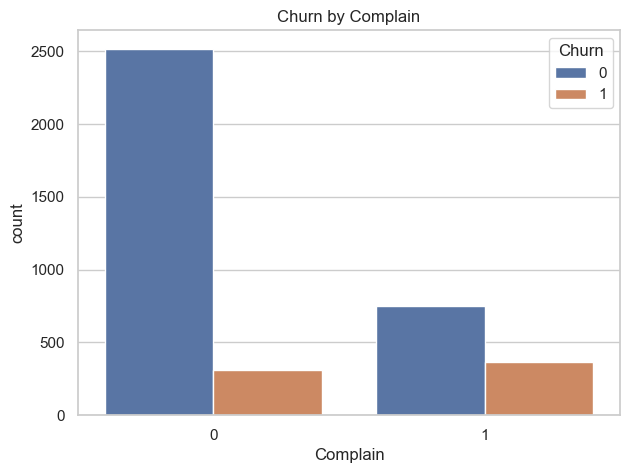

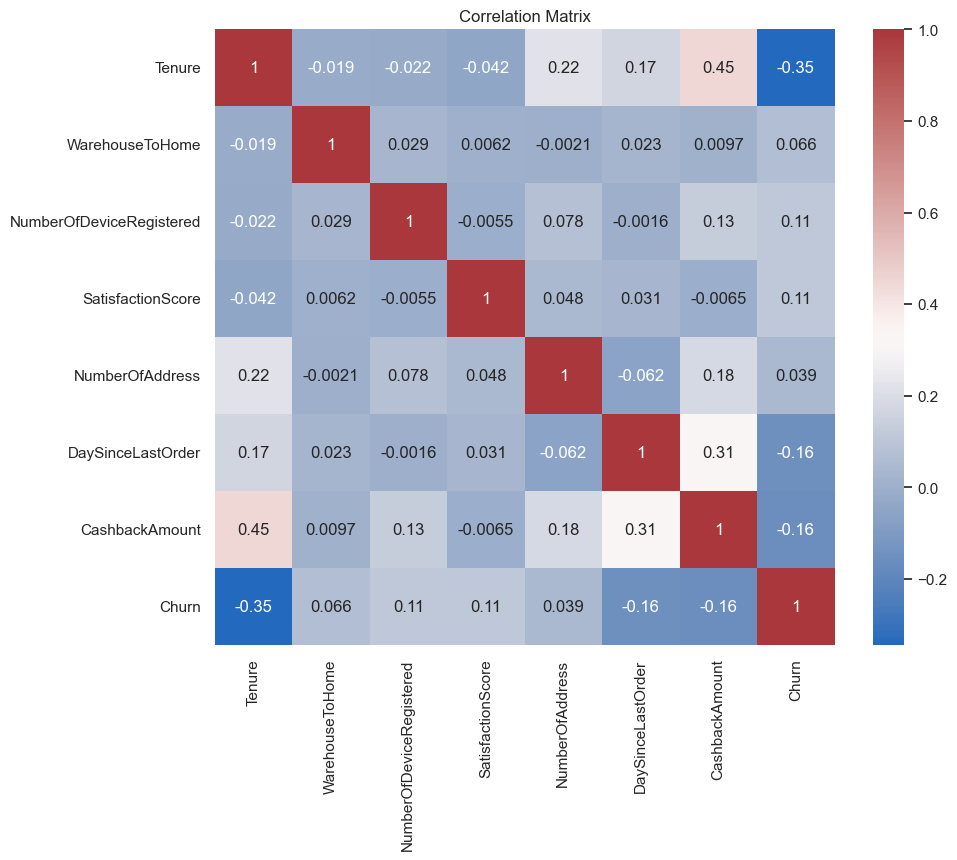

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Distribusi numerik + outlier
for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[col], kde=True, ax=ax[0])
    ax[0].set_title(col)
    sns.boxplot(x=df[col], ax=ax[1])
    ax[1].set_title(f"Outlier: {col}")
    plt.show()

# Churn vs Categorical
for col in cat_cols:
    plt.figure(figsize=(7, 5))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f"Churn by {col}")
    plt.show()

# Korelasi fitur
corr = df[num_cols + ['Churn']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='vlag')
plt.title('Correlation Matrix')
plt.show()

### Distribusi Numerik dan Outlier:
- `Tenure` didominasi pelanggan dengan masa berlangganan 10–30 bulan, outlier di bawah 5.
- `CashbackAmount` umumnya di bawah 300, namun memiliki banyak outlier.
- `DaySinceLastOrder` menunjukkan keterlambatan pemesanan lebih dari 100 hari pada banyak pelanggan.
- Distribusi fitur lainnya relatif normal namun tetap memiliki outlier minor.

### Distribusi Churn terhadap Fitur Kategorikal:
- `PreferedOrderCat`: Variasi rasio churn signifikan antar kategori.
- `Complain`: Pelanggan yang pernah komplain lebih rentan churn.
- `MaritalStatus`: Perbedaan rasio churn antar status relatif kecil namun tetap terlihat.

## Korelasi antar Fitur

### Korelasi Churn terhadap Fitur Numerik:
| Fitur                      | Korelasi terhadap Churn |
|----------------------------|--------------------------|
| Tenure                     | **-0.35**                |
| CashbackAmount             | **-0.16**                |
| DaySinceLastOrder          | **-0.16**                |
| NumberOfDeviceRegistered   | +0.11                    |
| SatisfactionScore          | +0.11                    |
| WarehouseToHome            | +0.066                   |
| NumberOfAddress            | +0.039                   |

### Catatan:
- Korelasi negatif artinya makin tinggi nilai fitur, makin kecil kemungkinan churn.
---

## Pemodelan Machine Learning
### Model yang diuji:
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM
- Ensemble: Voting dan Stacking

### Skema Evaluasi:
- Stratified 5-Fold Cross Validation
- Metrik utama: **F1 Score** (karena data imbalance)

In [6]:
# Data Splitting
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (3152, 10), Testing set size: (789, 10)


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Preprocessing Pipeline
num_cols = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 
            'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']
cat_cols = ['PreferedOrderCat', 'MaritalStatus', 'Complain']

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_cols)
], remainder='drop')

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

# Model Definitions
models = {
    'rf': RandomForestClassifier(random_state=42),
    'gb': GradientBoostingClassifier(random_state=42),
    'xgb': xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42),
    'lgb': lgb.LGBMClassifier(random_state=42)
}

In [10]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning
param_grid = {
    'rf': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5, 10]
    },
    'gb': {
        'clf__n_estimators': [100, 200, 300],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7]
    },
    'xgb': {
        'clf__n_estimators': [100, 200, 300],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7]
    },
    'lgb': {
        'clf__n_estimators': [100, 200, 300],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__num_leaves': [31, 50, 100]
    }
}

best_params = {}
for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    pipe = Pipeline([('pre', preprocessor), ('clf', model)])
    grid = GridSearchCV(pipe, param_grid[name], cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params[name] = grid.best_params_
    print(f"Best parameters for {name}: {grid.best_params_}")

Tuning hyperparameters for rf...


Best parameters for rf: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Tuning hyperparameters for gb...
Best parameters for gb: {'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Tuning hyperparameters for xgb...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best parameters for xgb: {'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 300}
Tuning hyperparameters for lgb...
[LightGBM] [Info] Number of positive: 359, number of negative: 1742[LightGBM] [Info] Number of positive: 360, number of negative: 1742
[LightGBM] [Info] Number of positive: 359, number of negative: 1742
[LightGBM] [Info] Number of positive: 359, number of negative: 1742

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004891 seconds.
You can set `force_col_wise=true` to r

In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Cross-validation
cv = StratifiedKFold(5, shuffle=True, random_state=42)
best_models = {}

for name, model in models.items():
    pipe = Pipeline([('pre', preprocessor), ('clf', model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    print(f"{name}: F1 mean={scores.mean():.3f}, std={scores.std():.3f}")
    best_models[name] = pipe

rf: F1 mean=0.765, std=0.032
gb: F1 mean=0.693, std=0.044


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:34:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:34:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:34:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:34:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

xgb: F1 mean=0.785, std=0.038
[LightGBM] [Info] Number of positive: 431, number of negative: 2090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 2521, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170964 -> initscore=-1.578811
[LightGBM] [Info] Start training from score -1.578811
[LightGBM] [Info] Number of positive: 431, number of negative: 2091
[LightGBM] [Info] Number of positive: 431, number of negative: 2090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Numb

In [12]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Ensemble Models
stack = StackingClassifier(
    estimators=[(name, best_models[name].named_steps['clf']) for name in best_models],
    final_estimator=LogisticRegression(),
    cv=cv,
    n_jobs=-1
)

vote = VotingClassifier(
    estimators=[(name, best_models[name].named_steps['clf']) for name in best_models],
    voting='soft',
    n_jobs=-1
)

# Evaluate Ensemble Models
for name, ensemble in [('Stacking', stack), ('Voting', vote)]:
    pipe_ensemble = Pipeline([('pre', preprocessor), ('ens', ensemble)])
    scores = cross_val_score(pipe_ensemble, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    print(f"{name}: F1 mean={scores.mean():.3f}, std={scores.std():.3f}")

[21:34:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 431, number of negative: 2090
[LightGBM] [Info] Number of positive: 431, number of negative: 2090
[LightGBM] [Info] Number of positive: 431, number of negative: 2091
[LightGBM] [Info] Number of positive: 431, number of negative: 2091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 2521, number of used features: 18
[LightGBM] [Info] Number of data points in the train set: 2521, number of used features: 18
[LightGBM] [Info] [binary:

[21:34:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 344, number of negative: 1672
[LightGBM] [Info] Number of positive: 344, number of negative: 1673
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 2016, number of used features: 18
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170635 -> initscore=-1.581134
[LightGBM] [Info] Number of positive: 344, number of negative: 1672
[LightGBM] [Info] Number of positive: 344, number of negative: 1673
[LightGBM] [Info] Number of data point

[21:34:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:34:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

[LightGBM] [Info] Number of positive: 345, number of negative: 1672
[LightGBM] [Info] Number of positive: 345, number of negative: 1672
[LightGBM] [Info] Number of positive: 345, number of negative: 1672
[LightGBM] [Info] Number of positive: 345, number of negative: 1672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 2017, number of used features: 18
[LightGBM] [Info] Number of data points in the train set: 2017, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.171046 -> initscore=-1.578231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.171046 -> initscore=-1.5

[21:35:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 345, number of negative: 1672
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 2017, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.171046 -> initscore=-1.578231
[LightGBM] [Info] Start training from score -1.578231


[21:35:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:35:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:35:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:35:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 345, number of negative: 1672
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 2017, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.171046 -> initscore=-1.578231
[LightGBM] [Info] Start training from score -1.578231


[21:35:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 346, number of negative: 1672
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 2018, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.171457 -> initscore=-1.575337
[LightGBM] [Info] Start training from score -1.575337
[LightGBM] [Info] Number of positive: 346, number of negative: 1672
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 2018, number of used features: 18
[LightGBM] [Info] [binary:Bo

[21:35:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:35:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:35:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[21:35:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 431, number of negative: 2091
[LightGBM] [Info] Number of positive: 431, number of negative: 2090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 2522, number of used features: 18
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Total Bins

[21:35:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Voting: F1 mean=0.788, std=0.034


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:35:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 539, number of negative: 2613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 3152, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.171003 -> initscore=-1.578539
[LightGBM] [Info] Start training from score -1.578539
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       654
           1       0.92      0.75      0.82       135

    accuracy                           0.95       789
   macro avg       0.93      0.87      0.90       789
weighted avg       0.94      0.95      0.94       789

ROC AUC: 0.958


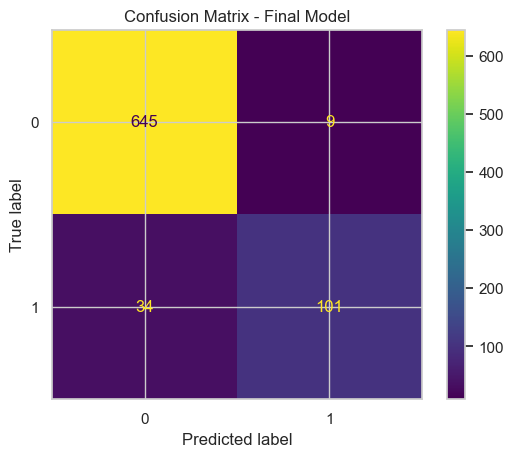

In [13]:
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Final Model Training and Testing
pipe_final = Pipeline([('pre', preprocessor), ('model', vote)])
pipe_final.fit(X_train, y_train)

y_pred = pipe_final.predict(X_test)
y_proba = pipe_final.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

ConfusionMatrixDisplay.from_estimator(pipe_final, X_test, y_test)
plt.title("Confusion Matrix - Final Model")
plt.show()

/var/folders/rb/swpbdkdx0wqdp48gb6zpkpj40000gn/T/ipykernel_8317/3229610844.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f1_means, y=model_names, palette='viridis')


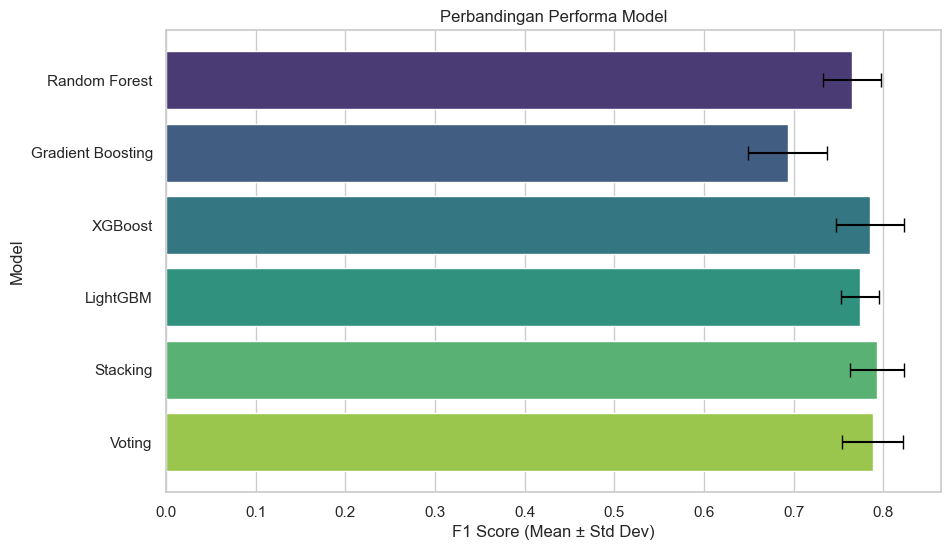

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data performa model
model_names = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'Stacking', 'Voting']
f1_means = [0.765, 0.693, 0.785, 0.774, 0.793, 0.788]
std_devs = [0.032, 0.044, 0.038, 0.021, 0.030, 0.034]

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=f1_means, y=model_names, palette='viridis')
plt.errorbar(f1_means, model_names, xerr=std_devs, fmt='none', c='black', capsize=5)
plt.xlabel('F1 Score (Mean ± Std Dev)')
plt.ylabel('Model')
plt.title('Perbandingan Performa Model')
plt.show()

[LightGBM] [Info] Number of positive: 539, number of negative: 2613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 3152, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.171003 -> initscore=-1.578539
[LightGBM] [Info] Start training from score -1.578539


/var/folders/rb/swpbdkdx0wqdp48gb6zpkpj40000gn/T/ipykernel_8317/3533092400.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


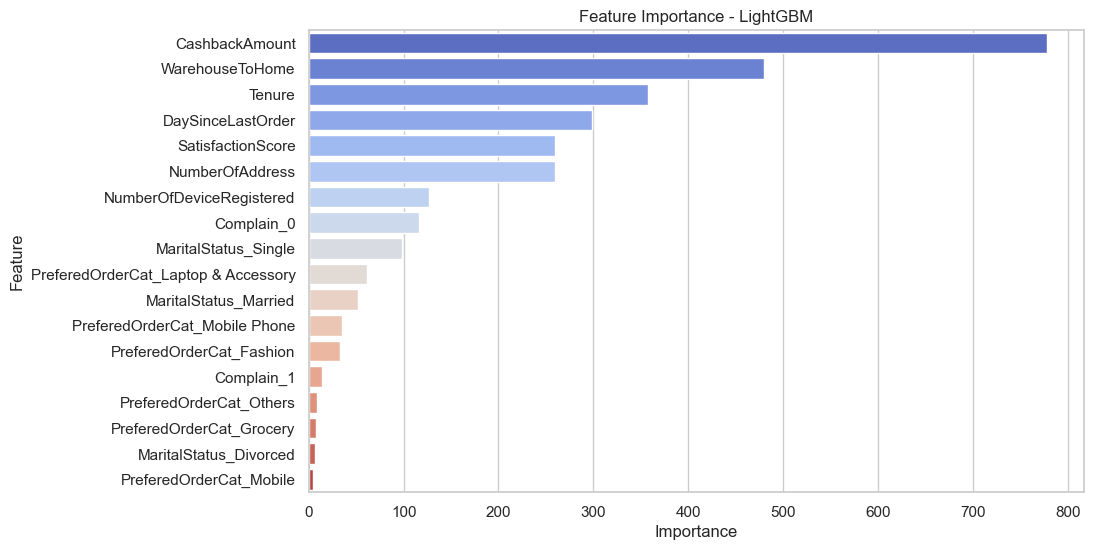

In [17]:
# Feature importance dari LightGBM
lgb_model = models['lgb']

# Preprocess the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Fit the model
lgb_model.fit(X_train_processed, y_train)

# Mendapatkan feature importance
feature_importance = lgb_model.feature_importances_
feature_names = preprocessor.named_transformers_['num'][1].get_feature_names_out(num_cols).tolist() + \
                preprocessor.named_transformers_['cat'][1].get_feature_names_out(cat_cols).tolist()

# Membuat DataFrame untuk visualisasi
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Barplot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.title('Feature Importance - LightGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Save dan Load Model dengan Pickle

Model dapat disimpan dan digunakan pada data set baru. Dibawah ini terdapat kode untuk me-load atau menggunakan model tersebut dengan dataset terbaru yang memiliki karakter yang sama dan melalui preprocessing yang sama dengan data yang digunakan untuk melatih model.

In [18]:
import pickle
# Simpan model ke file pickle
model_filename = 'final_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(pipe_final, file)

print(f"Model disimpan ke file: {model_filename}")

Model disimpan ke file: final_model.pkl


In [ ]:
# Muat model dari file pickle
with open('final_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Contoh penggunaan model yang dimuat
y_pred_loaded = loaded_model.predict(X_test)
print("Prediksi menggunakan model yang dimuat:", y_pred_loaded)

### Skema Evaluasi:
- **Stratified 5-Fold Cross Validation**
- **Metrik utama:** F1 Score (karena data imbalance)

### Hasil Evaluasi Model:
| Model         | F1 Mean | Std Dev |
|---------------|---------|---------|
| Random Forest | 0.765   | 0.032   |
| Gradient Boosting | 0.693   | 0.044   |
| XGBoost       | 0.785   | 0.038   |
| LightGBM      | 0.774   | 0.021   |

### Interpretasi:
- **XGBoost** memiliki performa terbaik dengan F1 mean = 0.785, namun stabilitasnya sedikit lebih rendah dibandingkan LightGBM.
- **LightGBM** memiliki stabilitas terbaik (std = 0.021) dengan performa mendekati XGBoost.
- **Gradient Boosting** memiliki performa terendah, sehingga kurang direkomendasikan.

---

# 📊 Interpretasi Figur

## 1. Perbandingan Performa Model (F1 Score Mean ± Std Dev)

| Model                | Mean F1 | Std Dev | Interpretasi Utama                                             |
|----------------------|---------|---------|----------------------------------------------------------------|
| Random Forest        | 0.765   | 0.032   | Stabil, tapi paling rendah dibanding boosting & ensemble       |
| Gradient Boosting    | 0.693   | 0.044   | Performa terendah dan fluktuasi tertinggi → perlu tuning      |
| XGBoost              | 0.785   | 0.038   | Mean tertinggi, namun varians masih cukup besar               |
| LightGBM             | 0.774   | 0.021   | Kinerja baik dan paling konsisten (std terendah)               |
| Stacking Classifier  | 0.793   | 0.030   | Ensemble terbaik rata-rata, stabilitas menengah               |
| Voting Classifier    | 0.788   | 0.034   | Performa hampir setara stacking, sedikit lebih berfluktuasi   |

**Penjelasan:**
- **Stacking** memiliki mean F1 tertinggi (0.793) dan stabilitas baik.  
- **XGBoost** unggul dalam mean, namun std dev (0.038) menunjukkan fluktuasi antar subset.  
- **LightGBM** pilihan optimal jika mengutamakan konsistensi di seluruh fold.  
- **Gradient Boosting** memerlukan hyper-tuning lebih lanjut karena mean rendah dan std tinggi.

---

## 2. Feature Importance – LightGBM

| Fitur                     | Importance | Interpretasi Utama                                    |
|---------------------------|------------|-------------------------------------------------------|
| CashbackAmount           | ~780       | Fitur paling berpengaruh: besarnya cashback menurunkan churn. |
| WarehouseToHome          | ~480       | Jarak pengiriman: pelanggan dekat gudang lebih setia.       |
| Tenure                   | ~360       | Lama berlangganan: pelanggan lama cenderung tidak churn.    |
| DaySinceLastOrder        | ~300       | Waktu sejak terakhir order: interval panjang → risiko naik.|
| SatisfactionScore        | ~260       | Skor kepuasan: rendahnya kepuasan meningkatkan churn.      |
| NumberOfAddress          | ~260       | Banyaknya alamat terdaftar → loyalitas sedikit lebih tinggi.|
| NumberOfDeviceRegistered | ~120       | Jumlah perangkat: indikator keterikatan moderat.           |
| Complain_0               | ~110       | Tidak pernah komplain → risiko churn lebih rendah.         |
| MaritalStatus_Single     | ~100       | Status lajang sedikit berisiko churn.                     |
| PreferedOrderCat_*       | ~10–50     | Kategori pesanan berpengaruh kecil                           |
| Complain_1               | ~15        | Pernah komplain → sedikit menaikkan risiko churn.          |

**Penjelasan:**
- **CashbackAmount** adalah pendorong utama retensi—semakin besar cashback, semakin kecil churn.  
- **WarehouseToHome** & **Tenure** menunjukkan pentingnya kedekatan & loyalitas waktu lama.  
- **DaySinceLastOrder** dan **SatisfactionScore** kritikal untuk intervensi cepat: pelanggan yang lama tidak order atau kurang puas harus diprioritaskan.  
- Fitur kategorikal (`PreferedOrderCat`, `MaritalStatus`, `Complain`) memiliki peran minor namun tetap memberikan sinyal tambahan.

---

## 3. Kesimpulan

- **Ensemble Stacking** memberikan performa terbaik secara rata-rata (F1 = 0.793).  
- **XGBoost** unggul dalam skor rata-rata, tetapi ada fluktuasi yang perlu dikendalikan.  
- **LightGBM** menawarkan kinerja yang konsisten dan cocok untuk produksi.  
- **Feature penting** untuk prediksi churn adalah `CashbackAmount`, `WarehouseToHome`, `Tenure`, `DaySinceLastOrder`, dan `SatisfactionScore`.  
- Model sudah memiliki **precision tinggi** dan **recall memadai**, namun peluang peningkatan terutama pada deteksi false negatives masih ada.

---

## 4. Rekomendasi

1. **Pilih Model untuk Produksi**  
   - Gunakan **LightGBM** untuk kestabilan, atau **Stacking Classifier** untuk performa puncak.

2. **Optimasi Hyperparameter**  
   - Tuning lebih lanjut pada **Gradient Boosting** (learning rate, max_depth).  
   - Atur regularisasi XGBoost untuk menurunkan varians.

3. **Intervensi Bisnis**  
   - **Cashback Strategis**: tingkatkan besaran cashback untuk pelanggan rawan churn.  
   - **Segmentasi Jarak**: tawarkan promosi khusus kepada pelanggan yang jauh dari gudang.

4. **Feature Engineering**  
   - Tambahkan fitur perilaku (frekuensi klik, durasi sesi).  
   - Transformasi `SatisfactionScore` jika pengkodean perlu koreksi.

5. **Monitoring & Feedback**  
   - Deploy model dengan monitoring performa real-time.  
   - Update model berkala berdasarkan data terbaru dan evaluasi drift.

---
